In [276]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

In [277]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

In [460]:
feats_import = pd.read_csv('All_Data_2006_2016.csv')
try:
    feats_import = feats_import.drop(['Unnamed: 0'], axis=1)
    print "Reshape successful"
except:
    print "Successful import"
feats_import.head()

Reshape successful


,Season,Gameday,Link,TID_H,TID_A,TName_H,TName_A,FTGD,HTGD,FTHG,...,AC,HY,AY,HR,AR,HP3,AP3,Interval_W,Interval_L,Interval_D
0,2006,1,2,0,12,Bayern Munich,Dortmund,2.0,1.0,2.0,...,4.0,1.0,2.0,0.0,0.0,0.5,0.5,0.733333,0.0,0.266667
1,2006,1,1,1,16,Hamburg,Bielefeld,0.0,-1.0,1.0,...,2.0,3.0,2.0,0.0,0.0,0.5,0.5,0.000000,0.0,1.000000
2,2006,1,8,2,10,Leverkusen,Aachen,3.0,2.0,3.0,...,1.0,3.0,0.0,1.0,1.0,0.5,0.5,0.644444,0.0,0.355556
3,2006,1,6,3,17,Mainz,Bochum,1.0,1.0,2.0,...,8.0,2.0,3.0,0.0,0.0,0.5,0.5,0.677778,0.0,0.322222
4,2006,1,3,4,11,M'gladbach,Cottbus,2.0,0.0,2.0,...,5.0,0.0,4.0,0.0,1.0,0.5,0.5,0.433333,0.0,0.566667


In [461]:
feats_import.columns

Index([u'Season', u'Gameday', u'Link', u'TID_H', u'TID_A', u'TName_H',
       u'TName_A', u'FTGD', u'HTGD', u'FTHG', u'HTHG', u'HGA', u'AGA', u'Odds',
       u'Attendance', u'ChancesA', u'ChancesH', u'HS', u'AS', u'HST', u'AST',
       u'HF', u'AF', u'HC', u'AC', u'HY', u'AY', u'HR', u'AR', u'HP3', u'AP3',
       u'Interval_W', u'Interval_L', u'Interval_D'],
      dtype='object')

In [351]:
# feats_import.loc[:, 'ChancesH'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'ChancesH'])))

In [352]:
# feats_import.loc[:, 'ChancesA'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'ChancesA'])))

In [353]:
# feats_import.loc[feats_import['Attendance']<1, 'Attendance'].plot(kind='hist', bins=40)

In [354]:
# feats_import.loc[:, 'HS'].plot(kind='hist', bins=int(max(feats_import.loc[:, 'HS'])))

In [16]:
# Test dropping out certain features, outdated. 

# kfold = KFold(n_splits=10, shuffle=True)

# performance_list = []
# for i in range(1,21,2):
#     if i<3:
#         continue
#     np.random.seed(7)
#     X_vary = np.delete(X,(i,i+1),1)
    
#     def baseline_model():
#         model = Sequential()
#         model.add(Dense(40, input_dim=len(X_vary[0]), init='uniform', activation='relu')) 
#         # model.add(Dropout(0.3))
#         model.add(Dense(20, activation='sigmoid'))
#         model.add(Dense(80, activation='relu'))
#         model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))

#         model.compile(optimizer='adam',
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])
#         return model
#     estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=20, batch_size=20, verbose=0)
    
#     results = cross_val_score(estimator, X_vary, y, cv=kfold)
#     print feats.columns[i:i+2]
#     print [i, 100*results.mean(), 100*results.std()]
#     performance_list += [i, 100*results.mean(), 100*results.std()]


In [17]:
# Outdated

# np.random.seed(7)
# X_vary = X

# def baseline_model():
#     model = Sequential()
#     model.add(Dense(40, input_dim=len(X_vary[0]), init='lecun_uniform', activation='relu')) 
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(2*cutoff_GD+1, activation='sigmoid'))
#     model.add(Activation('softmax'))

#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model
# estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=100, batch_size=10, verbose=0)

# results = cross_val_score(estimator, X_vary, y)
# print 100*results.mean(), 100*results.std()

In [356]:
teams_df = pd.read_csv('Team_ID_hardcoded.csv')

In [362]:
# Goal differential Cut-off.
cutoff_GD = 3

feats = feats_import.drop(['Season', 'Gameday', u'Link', u'TID_H', u'TID_A', u'TName_H', u'TName_A', 'Odds'], axis=1).drop('FTGD', axis=1)
feats.loc[:, 'HTGD'] = feats_import.loc[:, 'HTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1

# Different norms because I played around with different columns
norm = [GD_spread-1, 9, 5, 1, 1, 1, 22, 22, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 1, 1, GD_spread-1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, GD_spread-1, 1, 1, 1]

feats = feats/norm

season15_end = feats_import[feats_import['Season']==2016].index[0]
ID = np.eye(GD_spread)

X = feats.iloc[:season15_end].as_matrix()
y_pre = map(int, label.iloc[:season15_end].as_matrix())

y = np.array([ID[i] for i in y_pre])



In [363]:
# Thinking about new features like conversion rate for shots etc.

conversion_df = feats_import.loc[:, ['FTGD', 'FTHG', 'HS', 'HST', 'AS', 'AST', 'HGA', 'AGA']]
conversion_df.loc[:, 'HGoals'] = conversion_df.loc[:, 'FTHG']
conversion_df.loc[:, 'AGoals'] = np.abs(conversion_df.loc[:, 'FTGD'] - conversion_df.loc[:, 'HGoals'])
conversion_df.loc[:, 'HConv'] = conversion_df.loc[:, 'HST'] / conversion_df.loc[:, 'HS']
conversion_df.loc[:, 'AConv'] = conversion_df.loc[:, 'AST'] / conversion_df.loc[:, 'AS']

conversion_df.loc[:, 'GD_color'] = (conversion_df.loc[:, 'FTGD'] - np.min(conversion_df.loc[:, 'FTGD']))

# conversion_df.plot.hexbin(x='AConv', y='AGoals', C='AGA', gridsize=30)

In [364]:
# Assign an expected score with probabilities
def exp_score(x):
    multiplier = np.array(range(-cutoff_GD, cutoff_GD+1))
    # multiplier = np.array([-2.5, 1, 0, 1, 2.7])
    return np.sum(np.array(x) * multiplier)

In [373]:
# Run Keras
np.random.seed(7)

# I tested these parameters a little bit; they seem to work nicely for know.
model = Sequential()
model.add(Dense(50, input_dim=len(X[0]), init='lecun_uniform', activation='relu')) 
model.add(Dropout(0.4))
model.add(Dense(500, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*cutoff_GD+1, activation='relu'))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X, y, nb_epoch=100, batch_size=10, verbose=False)
print model.evaluate(X, y, batch_size=10, verbose=False)[1]

predictions = model.predict_proba(X)

0.712091504115
2912/3060 [===========================>..] - ETA: 0s

In [374]:
feats_import.head()

,Season,Gameday,Link,TID_H,TID_A,TName_H,TName_A,FTGD,HTGD,FTHG,...,AC,HY,AY,HR,AR,HP3,AP3,Interval_W,Interval_L,Interval_D
0,2006,1,2,0,12,Bayern Munich,Dortmund,2.0,1.0,2.0,...,4.0,1.0,2.0,0.0,0.0,0.5,0.5,0.733333,0.0,0.266667
1,2006,1,1,1,16,Hamburg,Bielefeld,0.0,-1.0,1.0,...,2.0,3.0,2.0,0.0,0.0,0.5,0.5,0.000000,0.0,1.000000
2,2006,1,8,2,10,Leverkusen,Aachen,3.0,2.0,3.0,...,1.0,3.0,0.0,1.0,1.0,0.5,0.5,0.644444,0.0,0.355556
3,2006,1,6,3,17,Mainz,Bochum,1.0,1.0,2.0,...,8.0,2.0,3.0,0.0,0.0,0.5,0.5,0.677778,0.0,0.322222
4,2006,1,3,4,11,M'gladbach,Cottbus,2.0,0.0,2.0,...,5.0,0.0,4.0,0.0,1.0,0.5,0.5,0.433333,0.0,0.566667


In [375]:
# Cross-Tabulation for Away-Win (-1), Draw (0) or Home-win (1)
performance_df = pd.concat([
        feats_import.iloc[:season15_end,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions)), name='EXP', index=feats_import.iloc[:season15_end].index)], axis=1)
success_res_df = pd.crosstab(performance_df.loc[:, "FTGD"].apply(np.sign), performance_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_res_df)/season15_end,2)) + " percent"
success_res_df


Success identifying H, D, A is 98.37 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,887,30,5
0.0,0,753,1
1.0,0,14,1370


In [376]:
# Cross-Tabulation for exact goal differential

success_df = pd.crosstab(performance_df.loc[:, "FTGD"], performance_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_df.loc[:, "EXP"].min())
exp_max = int(performance_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_df.ix[i,i] for i in range(exp_min,exp_max+1)])/season15_end,2)) + " percent"
success_df

Success identifying GD is 70.39 percent


EXP,-3.0,-2.0,-1.0,-0.0,1.0,2.0,3.0
FTGD,,,,,,,
-3.0,31,133,14,0,0,0,0
-2.0,0,145,129,1,1,0,0
-1.0,0,63,372,29,4,0,0
0.0,0,0,0,753,1,0,0
1.0,0,0,0,14,589,9,0
2.0,0,0,0,0,283,132,0
3.0,0,0,0,0,1,224,132


In [389]:
# Find all games that ended with an away win by one goal where the algorithm called a draw (Check invidiual games.)
# Example: Last two games all were won in last 30 minutes by away team after being behind until that point by 1 or 2 goals.
unexpected = pd.merge(
    pd.merge(
        pd.merge(
            performance_df[(performance_df['FTGD'].astype(int) != 0) & (performance_df['EXP'].astype(int) == 0)],
            feats_import.loc[:, ['TID_H', 'TID_A', 'Season', 'Gameday']], how='inner', left_index=True, right_index=True),
        teams_df,
        left_on='TID_H', right_on='TID').sort_values(['Season','Gameday']),
    teams_df,
    left_on='TID_A', right_on='TID', suffixes=('_H', '_A')).sort_values(['Season','Gameday']).drop(['TID_H', 'TID_A', 'KID_H', 'KID_A'], axis=1)


unexpected.loc[:, 'W'] = unexpected.loc[unexpected['FTGD']>0, 'TName_H']
unexpected.loc[:, 'L'] = unexpected.loc[unexpected['FTGD']>0, 'TName_A']

unexpected.loc[:, 'W'] = unexpected.loc[:, 'W'].fillna(unexpected.loc[:, 'TName_A'])
unexpected.loc[:, 'L'] = unexpected.loc[:, 'L'].fillna(unexpected.loc[:, 'TName_H'])

unexpected.loc[:, 'Unexpected_GD'] = unexpected.loc[:, 'FTGD'].apply(np.abs)


print unexpected.drop(['TName_H', 'TName_A', 'FTGD', 'EXP'], axis=1).groupby('W').count().loc[:, 'L']
print unexpected.drop(['TName_H', 'TName_A', 'FTGD', 'EXP'], axis=1).groupby('L').count().loc[:, 'W']

W
 Aachen           1
 Augsburg         1
 Bayern Munich    2
 Bochum           1
 Dortmund         2
 FC Koln          3
 Freiburg         4
 Hamburg          5
 Hannover         3
 Hertha           1
 Ingolstadt       1
 Leverkusen       1
 M'gladbach       5
 Mainz            1
 Nurnberg         1
 Schalke 04       3
 Stuttgart        2
 Werder Bremen    3
 Wolfsburg        4
Name: L, dtype: int64
L
 Bielefeld         1
 Bochum            1
 Braunschweig      2
 Cottbus           2
 Ein Frankfurt     4
 FC Koln           2
 Freiburg          2
 Greuther Furth    1
 Hamburg           3
 Hannover          2
 Hansa Rostock     1
 Hertha            1
 Hoffenheim        2
 Kaiserslautern    1
 Leverkusen        1
 M'gladbach        3
 Mainz             2
 Nurnberg          2
 Paderborn         1
 Schalke 04        3
 St Pauli          1
 Stuttgart         1
 Werder Bremen     1
 Wolfsburg         4
Name: W, dtype: int64


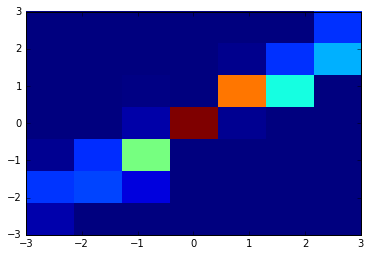

In [390]:
# Matrix Plot to visualize predictions vs. outcome

# x-axis: Actual outcome
# y-axis: Expected score (EXP)
plt_x = np.array(performance_df.loc[:, "FTGD"])
plt_y = np.array(performance_df.loc[:, "EXP"])

fig, ax = plt.subplots()

plt.hist2d(plt_x, plt_y, bins=2*cutoff_GD+1, range=np.array([(-cutoff_GD,cutoff_GD), (-cutoff_GD,cutoff_GD)]))
plt.show()

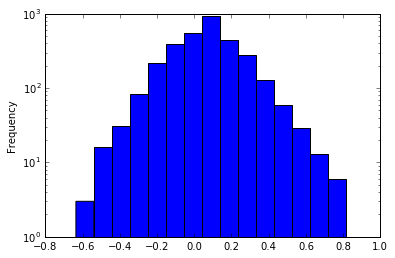

In [391]:
fig, ax = plt.subplots()
ax.set_yscale('log')
(feats.loc[:, "ChancesH"]-feats.loc[:, "ChancesA"]).plot(kind='hist', bins=15)

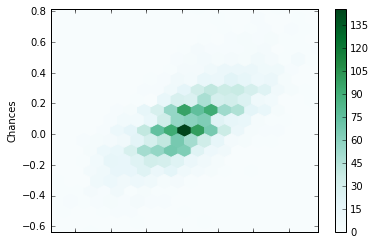

In [216]:
pd.concat([(feats.loc[:, "ChancesH"]-feats.loc[:, "ChancesA"]).rename('Chances'),
           (feats.loc[:, "HGA"]-feats.loc[:, "AGA"]).rename('G')],axis=1).plot.hexbin(y='Chances', x='G', gridsize=20)

In [392]:
# Define luck: Wherever our original algorithm was wrong.
# This needs to be refined obviously.
# Create df with only correctly predicted games and then learn on them
feats.loc[:, 'luck'] = (performance_df.loc[:, 'FTGD'] - performance_df.loc[:, 'EXP']).apply(np.abs).apply(np.sign)
feats_noluck = feats[feats['luck']==0].drop('luck', axis=1)

label = feats_import.loc[:, 'FTGD'].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)) + cutoff_GD

GD_min = -cutoff_GD
GD_max = +cutoff_GD
GD_spread = GD_max-GD_min + 1


# Different norms because I played around with different columns
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, 1, 1, GD_spread-1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 1, 1, GD_spread-1, 1, 1, 1]
#norm = [9, 5, 36, 36, 36, 33, 35, 35, 20, 20, 11, 11, 4, 4, GD_spread-1, 1, 1, 1]

feats_noluck = feats[feats['luck']==0].drop('luck', axis=1)
label_noluck = label.to_frame().merge(feats_noluck, left_index=True, right_index=True).loc[:, 'FTGD']


# ID for index to find end of 2015/16 season
ID = np.eye(GD_spread)

X_noluck = feats_noluck.ix[:season15_end].as_matrix()
y_pre_noluck = map(int, label_noluck.ix[:season15_end].as_matrix())

y_noluck = np.array([ID[i] for i in y_pre_noluck])

In [393]:
# Run Keras
np.random.seed(7)

# I tested these parameters a little bit; they seem to work nicely for know.
model_noluck = Sequential()
model_noluck.add(Dense(50, input_dim=len(X_noluck[0]), init='lecun_uniform', activation='relu')) 
model_noluck.add(Dropout(0.4))
model_noluck.add(Dense(500, activation='relu'))
model_noluck.add(Dense(50, activation='relu'))
model_noluck.add(Dropout(0.4))
model_noluck.add(Dense(2*cutoff_GD+1, activation='relu'))
model_noluck.add(Activation('softmax'))

model_noluck.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_noluck.fit(X_noluck, y_noluck, nb_epoch=100, batch_size=10, verbose=False)
print model_noluck.evaluate(X_noluck, y_noluck, batch_size=10, verbose=False)[1]

predictions_noluck = model_noluck.predict_proba(X_noluck)

0.917827290745
1952/2154 [==========================>...] - ETA: 0s

False

## EVERYTHING BELOW HERE IS NOT FULLY WORKING YET.

In [395]:
performance_noluck_df = pd.concat([
        (label_noluck.ix[:season15_end]-cutoff_GD).apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_noluck)), name='EXP', index=label_noluck.ix[:season15_end].index)], axis=1)
success_noluck_res_df = pd.crosstab(performance_noluck_df.loc[:, "FTGD"].apply(np.sign), performance_noluck_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100. * np.trace(success_noluck_res_df)/len(label_noluck.ix[:season15_end]),2)) + " percent"
success_noluck_res_df



Success identifying H, D, A is 99.72 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,547,1,0
0.0,0,753,0
1.0,0,5,848


In [396]:
success_noluck_df = pd.crosstab(performance_noluck_df.loc[:, "FTGD"], performance_noluck_df.loc[:, "EXP"])#, margins=True)
exp_min = int(performance_noluck_df.loc[:, "EXP"].min())
exp_max = int(performance_noluck_df.loc[:, "EXP"].max())
print "Success identifying GD is " + str(round(np.sum([100.*success_noluck_df.ix[i,i] for i in range(exp_min,exp_max+1)])/len(performance_noluck_df),2)) + " percent"
success_noluck_df

Success identifying GD is 91.78 percent


EXP,-2.0,-1.0,0.0,1.0,2.0,3.0
FTGD,,,,,,
-3.0,30,1,0,0,0,0
-2.0,65,80,0,0,0,0
-1.0,0,371,1,0,0,0
0.0,0,0,753,0,0,0
1.0,0,0,5,584,0,0
2.0,0,0,0,54,78,0
3.0,0,0,0,0,6,126


In [398]:
len(X_test)

125

In [404]:
X_test = feats.iloc[season15_end+1:].drop('luck', axis=1).as_matrix()
y_test_pre = map(int, label.iloc[season15_end+1:].as_matrix())

y_test = np.array([ID[i] for i in y_test_pre])

predictions_new_season = model.predict_proba(X_test)
predictions_new_season_noluck = model_noluck.predict_proba(X_test)
print '\n'

# Measure performance without thinking about luck
performance_new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_new_season)), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)
success_new_season_res_df = pd.crosstab(performance_new_season_df.loc[:, "FTGD"].apply(np.sign), performance_new_season_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100.* np.trace(success_new_season_res_df)/len(X_test),2)) + " percent"
success_new_season_res_df

 32/125 [======>.......................] - ETA: 0s

Success identifying H, D, A is 98.4 percent


EXP,-1.0,0.0,1.0
FTGD,,,
-1.0,33,1,0
0.0,0,31,0
1.0,0,1,59


### How many goals are scored more for the winning on average when the GD > cutoff

In [405]:
weights = feats_import.ix[:, 'FTGD'].value_counts(False, False, True).to_frame()
weights.loc[:, 'GD'] = weights.index
bla = weights[weights['GD']>=cutoff_GD]
print bla
print np.sum(bla.loc[:, 'FTGD']*bla.loc[:, 'GD'])/np.sum(bla.loc[:, 'FTGD'])

     FTGD   GD
3.0   222  3.0
4.0   100  4.0
5.0    32  5.0
6.0     8  6.0
7.0     6  7.0
8.0     1  8.0
3.58807588076


In [407]:
new_season_noluck_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(exp_score, predictions_new_season_noluck), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)

new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(exp_score, predictions_new_season), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)

In [408]:
comparison_df = pd.concat([new_season_df, new_season_noluck_df.loc[:, 'EXP'].rename('EXP w/o luck')], axis=1).apply(np.round, args=(2,))

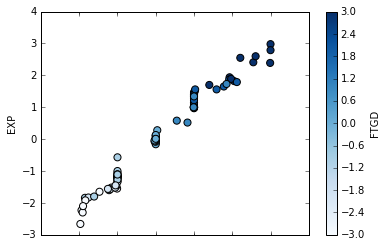

In [409]:
comparison_df.plot(kind='scatter', x='EXP w/o luck', y='EXP', c='FTGD', s=50, colormap='Blues')

In [413]:
output_df = pd.merge(new_season_df, feats_import.loc[:, ['TID_H', 'TID_A', 'Gameday']], how='inner', left_index=True, right_index=True)
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_H', right_on='TID')
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_A', right_on='TID')

output_df = output_df.drop(['TID_x', 'TID_y'], axis=1)



tid = 5
# pd.merge(output_df.query('TID_A==5'), output_df.query('TID_H==5'))
schalke_df = pd.concat([output_df[output_df['TID_H'] == tid], output_df[output_df['TID_A'] == tid]], axis=0).drop(['TID_H', 'TID_A'], axis=1).sort_values(by='Gameday')
schalke_df = schalke_df.loc[:, ['Gameday', 'TName_x', 'TName_y', 'FTGD', 'EXP']].set_index('Gameday')
schalke_df.columns = ['Home_Team', 'Away_Team', 'Final', 'Expected']
schalke_df.loc[:, 'Expected'] = schalke_df.loc[:, 'Expected'].apply(np.round, args=(4,)) 
schalke_df

,Home_Team,Away_Team,Final,Expected
Gameday,,,,
1,Ein Frankfurt,Schalke 04,1.0,0.9992
2,Schalke 04,Bayern Munich,-2.0,-1.1848
3,Hertha,Schalke 04,2.0,1.3884
4,Schalke 04,FC Koln,-2.0,-1.2017
5,Hoffenheim,Schalke 04,1.0,0.9887
6,Schalke 04,M'gladbach,3.0,2.5538
7,Augsburg,Schalke 04,0.0,0.0895
8,Schalke 04,Mainz,3.0,1.9390
9,Dortmund,Schalke 04,0.0,-0.0548


In [427]:
feats_.loc[(feats_import['Season']==2016) & (feats_import['Gameday']==1)].drop('luck', axis=1)

,HTGD,FTHG,HTHG,HGA,AGA,Attendance,ChancesA,ChancesH,HS,AS,...,AC,HY,AY,HR,AR,HP3,AP3,Interval_W,Interval_L,Interval_D
3060,0.833333,0.666667,0.4,0.781818,0.136364,1.000000,0.000000,0.681818,0.750000,0.111111,...,0.05,0.000000,0.090909,0.00,0.0,0.5,0.5,0.900000,0.0,0.100000
3061,0.666667,0.111111,0.2,0.427273,0.445455,0.879070,0.136364,0.090909,0.222222,0.361111,...,0.25,0.181818,0.181818,0.00,0.0,0.5,0.5,0.000000,0.0,1.000000
3062,0.666667,0.222222,0.2,0.700000,0.581818,0.966101,0.272727,0.363636,0.388889,0.333333,...,0.15,0.272727,0.272727,0.00,0.0,0.5,0.5,0.433333,0.0,0.566667
3063,0.666667,0.222222,0.2,0.563636,0.472727,1.000000,0.227273,0.272727,0.472222,0.333333,...,0.10,0.000000,0.272727,0.00,0.0,0.5,0.5,0.811111,0.0,0.188889
3064,0.666667,0.111111,0.2,0.618182,0.354545,0.912621,0.090909,0.272727,0.305556,0.305556,...,0.25,0.181818,0.181818,0.25,0.0,0.5,0.5,0.855556,0.0,0.144444
3065,0.500000,0.222222,0.0,0.590909,0.445455,0.687533,0.136364,0.272727,0.416667,0.222222,...,0.10,0.000000,0.272727,0.00,0.0,0.5,0.5,0.311111,0.0,0.688889
3066,0.500000,0.222222,0.0,0.554545,0.618182,0.813315,0.409091,0.227273,0.305556,0.638889,...,0.45,0.181818,0.363636,0.00,0.0,0.5,0.5,0.000000,0.0,1.000000
3067,0.666667,0.222222,0.2,0.690909,0.354545,1.000000,0.090909,0.454545,0.583333,0.333333,...,0.25,0.272727,0.272727,0.00,0.0,0.5,0.5,0.877778,0.0,0.122222
3068,0.333333,0.000000,0.0,0.418182,0.581818,0.853620,0.181818,0.045455,0.361111,0.333333,...,0.15,0.090909,0.181818,0.00,0.0,0.5,0.5,0.611111,0.0,0.388889


In [437]:
new_feats_import_df.loc[:, 'TID_H']

3060     0
3061     1
3062     4
3063    12
3064    13
3065    14
3066    21
3067    22
3068    26
Name: TID_H, dtype: int64

In [447]:
new_feats_df = feats.loc[(feats_import['Season']==2016) & (feats_import['Gameday']==1)].drop('luck', axis=1)
new_feats_import_df = feats_import.loc[(feats_import['Season']==2016) & (feats_import['Gameday']==1)]
X_test_gameday = new_feats_df.as_matrix()

y_test_gameday_pre = map(int, label.iloc[season15_end:season15_end+9].as_matrix())
y_test_gameday = np.array([ID[i] for i in y_test_gameday_pre])

predictions_new_gameday = model.predict_proba(X_test_gameday)

data = np.array([np.ones(9),
new_feats_import_df.loc[:, 'TID_H'].tolist(),
new_feats_import_df.loc[:, 'TID_A'].tolist(),
map(exp_score, predictions_new_gameday)]).T

simulated_df = pd.DataFrame(data=data, columns=['Gameday', 'TID_H', 'TID_A', 'GD'])


9/9 [==============================] - 0s


In [457]:
def points(x):
    if x > 0:
        return 3
    elif x == 0:
        return 1
    else:
        return 0
    
simulated_df.loc[:, "P_W"] = simulated_df.loc[:, "GD"].apply(np.round).apply(points)
simulated_df.loc[:, "P_L"] = (-simulated_df.loc[:, "GD"]).apply(np.round).apply(points)

simulated_df.loc[:, "W"] = simulated_df.loc[:, "GD"].apply(np.round).apply(np.sign)

simulated_df

,Gameday,TID_H,TID_A,GD,P_W,P_L,W
0,1.0,0.0,15.0,2.980693,3,0,1.0
1,1.0,1.0,32.0,-0.000127,1,1,0.0
2,1.0,4.0,2.0,1.004178,3,0,1.0
3,1.0,12.0,3.0,1.023144,3,0,1.0
4,1.0,13.0,5.0,0.999236,3,0,1.0
5,1.0,14.0,23.0,1.224183,3,0,1.0
6,1.0,21.0,33.0,0.002335,1,1,0.0
7,1.0,22.0,31.0,1.284068,3,0,1.0
8,1.0,26.0,8.0,-1.518213,0,3,-1.0


In [453]:
feats_import.iloc[season15_end:]

,Season,Gameday,Link,TID_H,TID_A,TName_H,TName_A,FTGD,HTGD,FTHG,...,AC,HY,AY,HR,AR,HP3,AP3,Interval_W,Interval_L,Interval_D
3060,2016,1,3061,0,15,Bayern Munich,Werder Bremen,6.0,2.0,6.0,...,1.0,0.0,1.0,0.0,0.0,0.500,0.500,0.900000,0.000000,0.100000
3061,2016,1,3060,1,32,Hamburg,Ingolstadt,0.0,1.0,1.0,...,5.0,2.0,2.0,0.0,0.0,0.500,0.500,0.000000,0.000000,1.000000
3062,2016,1,3062,4,2,M'gladbach,Leverkusen,1.0,1.0,2.0,...,3.0,3.0,3.0,0.0,0.0,0.500,0.500,0.433333,0.000000,0.566667
3063,2016,1,3064,12,3,Dortmund,Mainz,1.0,1.0,2.0,...,2.0,0.0,3.0,0.0,0.0,0.500,0.500,0.811111,0.000000,0.188889
3064,2016,1,3066,13,5,Ein Frankfurt,Schalke 04,1.0,1.0,1.0,...,5.0,2.0,2.0,1.0,0.0,0.500,0.500,0.855556,0.000000,0.144444
3065,2016,1,3065,14,23,Hertha,Freiburg,1.0,0.0,2.0,...,2.0,0.0,3.0,0.0,0.0,0.500,0.500,0.311111,0.000000,0.688889
3066,2016,1,3067,21,33,Hoffenheim,RB Leipzig,0.0,0.0,2.0,...,9.0,2.0,4.0,0.0,0.0,0.500,0.500,0.000000,0.000000,1.000000
3067,2016,1,3063,22,31,FC Koln,Darmstadt,2.0,1.0,2.0,...,5.0,3.0,3.0,0.0,0.0,0.500,0.500,0.877778,0.000000,0.122222
3068,2016,1,3068,26,8,Augsburg,Wolfsburg,-2.0,-1.0,0.0,...,3.0,1.0,2.0,0.0,0.0,0.500,0.500,0.611111,0.000000,0.388889
3069,2016,2,3076,2,1,Leverkusen,Hamburg,2.0,0.0,3.0,...,1.0,2.0,1.0,0.0,0.0,0.000,0.333,0.000000,0.233333,0.766667


In [ ]:

print '\n'

# Measure performance without thinking about luck
performance_new_season_df = pd.concat([
        feats_import.iloc[season15_end+1:,7].apply(min, args=(cutoff_GD,)).apply(max, args=(-cutoff_GD,)),
        pd.Series(data=map(np.round, map(exp_score, predictions_new_season)), name='EXP', index=feats_import.iloc[season15_end+1:].index)], axis=1)
success_new_season_res_df = pd.crosstab(performance_new_season_df.loc[:, "FTGD"].apply(np.sign), performance_new_season_df.loc[:, "EXP"].apply(np.sign))
print "Success identifying H, D, A is " + str(round(100.* np.trace(success_new_season_res_df)/len(X_test),2)) + " percent"
success_new_season_res_df

In [412]:
output_df = pd.merge(new_season_noluck_df, feats_import.loc[:, ['TID_H', 'TID_A', 'Gameday']], how='inner', left_index=True, right_index=True)
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_H', right_on='TID')
output_df = pd.merge(output_df, teams_df.loc[:, ['TID', 'TName']], how='inner', left_on='TID_A', right_on='TID')

output_df = output_df.drop(['TID_x', 'TID_y'], axis=1)



tid = 33
# pd.merge(output_df.query('TID_A==5'),           output_df.query('TID_H==5'))
schalke_df = pd.concat([output_df[output_df['TID_H'] == tid], output_df[output_df['TID_A'] == tid]], axis=0).drop(['TID_H', 'TID_A'], axis=1).sort_values(by='Gameday')
schalke_df = schalke_df.loc[:, ['Gameday', 'TName_x', 'TName_y', 'FTGD', 'EXP']].set_index('Gameday')
schalke_df.columns = ['Home_Team', 'Away_Team', 'Final', 'Expected']
schalke_df.loc[:, 'Expected'] = schalke_df.loc[:, 'Expected'].apply(np.round, args=(4,)) 
schalke_df

,Home_Team,Away_Team,Final,Expected
Gameday,,,,
1,Hoffenheim,RB Leipzig,0.0,0.0000
2,RB Leipzig,Dortmund,1.0,0.5536
3,Hamburg,RB Leipzig,-3.0,-1.0142
4,RB Leipzig,M'gladbach,0.0,0.0000
5,FC Koln,RB Leipzig,0.0,0.0000
6,RB Leipzig,Augsburg,1.0,1.0003
7,Wolfsburg,RB Leipzig,-1.0,-1.0005
8,RB Leipzig,Werder Bremen,2.0,1.7824
9,Darmstadt,RB Leipzig,-2.0,-1.0577


,Season,Gameday,Link,Score,Minute,Player
0,2006.0,1.0,0.0,-1.0,37.0,30176.0
1,2006.0,1.0,0.0,-2.0,45.0,144.0
2,2006.0,1.0,0.0,-3.0,78.0,27610.0
3,2006.0,1.0,1.0,-1.0,32.0,29515.0
4,2006.0,1.0,1.0,0.0,67.0,37363.0
5,2006.0,1.0,2.0,1.0,24.0,25031.0
6,2006.0,1.0,2.0,2.0,55.0,27701.0
7,2006.0,1.0,3.0,1.0,51.0,27510.0
8,2006.0,1.0,3.0,2.0,60.0,9039.0
9,2006.0,1.0,4.0,1.0,30.0,26143.0
